In [50]:
# imports
import pandas as p
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import gc                           # garbage collector

# constants
FOLDER_PATH = "../dataset/2019/"
FILE_NAME = 'cleaned_2019_01-03.csv'
SPEED_THRESHOLD = 0.3 # nautical knots
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots
EARTH_RADIUS_KM = 6378.137 # average value, used by geopy https://github.com/geopy/geopy/blob/master/geopy/distance.py
EARTH_RADIUS_M = 6378137
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957

Import source csv into a dataframe

In [51]:
clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)

Dataframe shape: (5415168, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')


Columns dtypes optimization in order to reduce RAM usage <br>
(=casting to smaller dtypes)

In [52]:
optimized_df = p.DataFrame()

# MMSI - 9 digits number, converted from int64 to int32
optimized_df['MMSI'] = clean_df['MMSI'].astype('int32')

# BaseDateTime - from str to numpy.datetime64 (68 bytes -> 40 Bytes)
optimized_df['BaseDateTime'] = clean_df['BaseDateTime'].astype('datetime64[s]')

# LAT - from float64 to float32. The loss of precision of float32 is negligible, 
# as latitude values span from LAT_MIN to LAT_MAX
optimized_df['LAT'] = clean_df['LAT'].astype('float32')

# LON - from float64 to float32. The loss of precision of float32 is negligible, 
# as latitude values span from LON_MIN to LON_MAX
optimized_df['LON'] = clean_df['LON'].astype('float32')

# SOG - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value for SOG is 102 (knots)
optimized_df['SOG'] = clean_df['SOG'].astype('float32')

# COG - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 360 degrees, relative to true north
optimized_df['COG'] = clean_df['COG'].astype('float32')

# Heading - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 511, meaning 'no data'.
optimized_df['Heading'] = clean_df['Heading'].astype('float32')

# VesselName - string object, no action
optimized_df['VesselName'] = clean_df['VesselName']

# IMO - string object, no action
optimized_df['IMO'] = clean_df['IMO']

# CallSign - string object, no action
optimized_df['CallSign'] = clean_df['CallSign']

# VesselType - from float64 to int16. Following AIS specification, VesselType maximum value is around 1000
clean_df['VesselType'] = clean_df['VesselType'].fillna(value=0) # replaces all None values with zero.
optimized_df['VesselType'] = clean_df['VesselType'].astype('int16')

# Status - from float64 to int8. Following AIS specification, there are 16 (0-15) status codes
clean_df['Status'] = clean_df['Status'].fillna(value=99) # since 0 is a valid status code, 99 is used as a placeholder for None values
optimized_df['Status'] = clean_df['Status'].astype('int8')

# Length - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Length'] = clean_df['Length'].fillna(value=0)
optimized_df['Length'] = clean_df['Length'].astype('int16')

# Width - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Width'] = clean_df['Width'].fillna(value=0)
optimized_df['Width'] = clean_df['Width'].astype('int16')

# Draft - from float64 to float32
optimized_df['Draft'] = clean_df['Draft'].astype('float32')

# Cargo - from float64 to int16. Similar to VesselType
clean_df['Cargo'] = clean_df['Cargo'].fillna(value=0)
optimized_df['Cargo'] = clean_df['Cargo'].astype('int16')

# TransceiverClass - from string object to boolean. The new column ('IsClassA') holds True if the transceiver 
# is of type 'class A', false if it is of type 'class B'
optimized_df['IsClassA'] = clean_df['TransceiverClass'].map({'A':True, 'B':False})

print(clean_df.info())

print(optimized_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TransceiverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 702.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column        Dtype        
---  ------        -----        
 0   MMSI          int32        
 1   BaseDateTim

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [ ]:
def great_circle_distance_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = EARTH_RADIUS_M * c
    return meters

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# From the complete db, select only the necessary columns
optimized_df = optimized_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                            'VesselName', 'VesselType', 'Status', 'Length',
                            'Width', 'Draft', 'IsClassA']].copy()
# Drop duplicates, just in case
optimized_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)

# for each ship
for mmsi in p.unique(optimized_df['MMSI']):
    # Extract all points generated by the ship
    appendDF = p.DataFrame(optimized_df[optimized_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = np.nan
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['EstimatedStatus'] = np.nan
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points.
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the right one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two points of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that holds the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = great_circle_distance_vectorized( pairsOfPointsDF['LAT_left'],
                                                                    pairsOfPointsDF['LON_left'],
                                                                    pairsOfPointsDF['LAT_right'],
                                                                    pairsOfPointsDF['LON_right']
                                                                    )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()
    # convert it into nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * KNOTS_CONST
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].astype('float32').copy()
    # round the final value to 2 decimal digits
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

print(V_s[-1].info())


In [ ]:
# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del pairsOfPointsDF
del appendDF
del shiftedDF
del clean_df
gc.collect()

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   MMSI             1176 non-null   int32        
 1   BaseDateTime     1176 non-null   datetime64[s]
 2   LAT              1176 non-null   float32      
 3   LON              1176 non-null   float32      
 4   SOG              1176 non-null   float32      
 5   COG              1176 non-null   float32      
 6   Heading          1176 non-null   float32      
 7   VesselName       0 non-null      object       
 8   VesselType       1176 non-null   int16        
 9   Status           1176 non-null   int8         
 10  Length           1176 non-null   int16        
 11  Width            1176 non-null   int16        
 12  Draft            0 non-null      float32      
 13  IsClassA         1176 non-null   bool         
 14  Avg_Speed        1176 non-null   float32      
 15  Esti

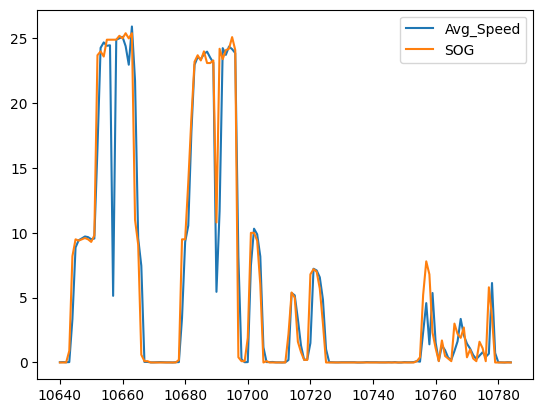

In [59]:
# for each vessel (dataframe) in the V_s list,

for shipDF in V_s:
    # set the status of each point where the avg_speed is lower than the given threshold, to 'stationary'
    shipDF['EstimatedStatus'] = np.where(shipDF["Avg_Speed"] < SPEED_THRESHOLD, 'stationary', shipDF['EstimatedStatus'])
    # set all remaining points as "sailing"
    shipDF['EstimatedStatus'] = np.where(shipDF["Avg_Speed"] >= SPEED_THRESHOLD, 'sailing', shipDF['EstimatedStatus'])
    # set the first 2 and last 2 points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:2], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-2:], 'EstimatedStatus'] = 'exit'

print(shipDF.info())

del shipDF
gc.collect()

# print a dataframe and some points just to check
interval = range(10640,10785)
print(V_s[3].iloc[interval])
plt.plot(V_s[3]['Avg_Speed'].iloc[interval])
plt.plot(V_s[3]['SOG'].iloc[interval])
plt.legend(['Avg_Speed', 'SOG'])


In [60]:
# Extract all the stationary points in a single dataframe

stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

concatDF = p.concat(V_s, ignore_index=True).copy()
stationaryDF = concatDF[(concatDF['EstimatedStatus'] == 'stationary') |
                        (concatDF['EstimatedStatus'] == 'entry') |
                        (concatDF['EstimatedStatus'] == 'exit')
                        ].copy()

stationaryDF['EstimatedStatus'] = stationaryDF['EstimatedStatus'].astype('category')

print(stationaryDF.info())

print(f'{(stationaryDF.shape[0]/optimized_df.shape[0]) * 100: .2f}% of points are stationary!')

# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del concatDF
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Index: 3754153 entries, 0 to 5415162
Data columns (total 16 columns):
 #   Column           Dtype        
---  ------           -----        
 0   MMSI             int32        
 1   BaseDateTime     datetime64[s]
 2   LAT              float32      
 3   LON              float32      
 4   SOG              float32      
 5   COG              float32      
 6   Heading          float32      
 7   VesselName       object       
 8   VesselType       int16        
 9   Status           int8         
 10  Length           int16        
 11  Width            int16        
 12  Draft            float32      
 13  IsClassA         bool         
 14  Avg_Speed        float32      
 15  EstimatedStatus  category     
dtypes: bool(1), category(1), datetime64[s](1), float32(7), int16(3), int32(1), int8(1), object(1)
memory usage: 232.7+ MB
None
 69.33% of points are stationary!


24

In [46]:
# Some computationl tricks in order to save some time

# Round lat and lon values to 4 decimal digits (instead of 5)
stationaryDF = stationaryDF.round(decimals=4)
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['MMSI','LAT', 'LON', 'EstimatedStatus']).size().reset_index(name='Weight')

# remove 'stationaryDF' from RAM as it is no longer used

del stationaryDF
gc.collect()


print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
groupedDF['Weight'].replace(0,1,inplace=True)

print(groupedDF)

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')



Pair with most occurrencies: 
MMSI                368926122
LAT                 21.297001
LON               -158.106506
EstimatedStatus    stationary
Weight                  61905
Name: 42778, dtype: object

            MMSI        LAT         LON EstimatedStatus  Weight
0         382872  21.342400 -157.967606      stationary     3.0
1         382872  21.343599 -157.968002      stationary     1.0
2         382872  21.343599 -157.967896      stationary     2.0
3         382872  21.343700 -157.967896      stationary     1.0
4         382872  21.343700 -157.967804      stationary     1.0
...          ...        ...         ...             ...     ...
51390  981000633  21.583000 -157.613693            exit     1.0
51391  981000633  21.586901 -157.613205            exit     1.0
51392  981000633  21.947201 -157.207504      stationary     1.0
51393  981000633  22.437300 -158.341904           entry     1.0
51394  981000633  22.441401 -158.341507           entry     1.0

[51395 rows x 5 columns

/tmp/ipykernel_40347/1842045128.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  groupedDF['Weight'].replace(0,1,inplace=True)


DBSCAN(eps=0.1, min_samples=10) len: 51395, num of clusters: 51
            MMSI        LAT         LON EstimatedStatus  Weight  Label
0         382872  21.342400 -157.967606      stationary     3.0      0
1         382872  21.343599 -157.968002      stationary     1.0      0
2         382872  21.343599 -157.967896      stationary     2.0      0
3         382872  21.343700 -157.967896      stationary     1.0      0
4         382872  21.343700 -157.967804      stationary     1.0      0
...          ...        ...         ...             ...     ...    ...
51390  981000633  21.583000 -157.613693            exit     1.0     -1
51391  981000633  21.586901 -157.613205            exit     1.0     -1
51392  981000633  21.947201 -157.207504      stationary     1.0     -1
51393  981000633  22.437300 -158.341904           entry     1.0     -1
51394  981000633  22.441401 -158.341507           entry     1.0     -1

[51395 rows x 6 columns]


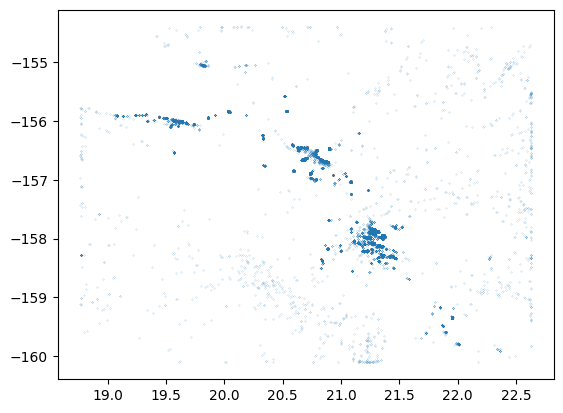

In [47]:
# Run DBSCAN algorithm on the stationary points

# this scatter plot gives a rough idea of how the point should look like plotted on a map
plt.scatter(groupedDF.iloc[:,1], groupedDF.iloc[:,2], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.10, min_samples=10)

estimator = dbscan.fit(
                    X=groupedDF.iloc[:, 1:3], 
                    sample_weight=groupedDF['Weight']
                    )

print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

print(groupedDF)


In [48]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()

outliersDF = groupedDF[groupedDF['Label'] == -1].copy()

# plot clustered points on a map
fig = px.scatter_mapbox(data_frame = clusteredPointsDF,
                        lon = clusteredPointsDF['LON'],
                        lat= clusteredPointsDF['LAT'],
                        zoom = 6,
                        color = clusteredPointsDF['Label'],
                        title = 'Clustered stationary points. Eps: ' + str(estimator.get_params()['eps']) + ', min_size: ' + str(estimator.get_params()['min_samples']),
                        color_continuous_scale='portland',  #portland
                        hover_data=['MMSI', 'EstimatedStatus']
                        )

# add unclustered points
fig.add_scattermapbox(
                      lat= outliersDF['LAT'],
                      lon= outliersDF['LON'],
                      below=0,
                      marker={'color':'white'},
                      hovertext=outliersDF[['MMSI','EstimatedStatus']]
                      )

# add domain border
fig.add_trace(go.Scattermapbox(
                                mode = 'lines',
                                lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                marker = {'size':10,
                                          'color': 'red'}
                                ))

clusteredPointsDF['LON'].add(0.1)

fig.add_trace(go.Scattermapbox(
        mode='lines',
        lon = np.column_stack([clusteredPointsDF['LON'], clusteredPointsDF['LON'].add(1)]),
        lat = np.column_stack([clusteredPointsDF['LAT'], clusteredPointsDF['LAT'].add(1)]),
        line = dict(width=2, color='black')
    )
)


fig.update_layout(mapbox_style = 'open-street-map',
                  margin={'r':0, 't':40, 'l':0, 'b':0},

                  )

po.plot(fig)

'temp-plot.html'